In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import os
from PIL import Image
import skimage as ski
from skimage.color import rgb2gray
from skimage import feature
import math

In [2]:
print(os.getcwd())
imdir = '/workspaces/isaac_ros-dev/src/LineFollower_Sim2Real/test_images'
imlist = os.listdir(imdir)
nb_images = len(imlist)
print(f"number of test images: {nb_images}")

/workspaces/isaac_ros-dev/src/LineFollower_Sim2Real/src/linepreprocessor/linepreprocessor
number of test images: 4


In [3]:
imdir + imlist[2]

'/workspaces/isaac_ros-dev/src/LineFollower_Sim2Real/test_imagesframe_1745474303313280341.png'

In [4]:
img = Image.open(imdir + '/' + imlist[2])
imarr = np.asarray(img)

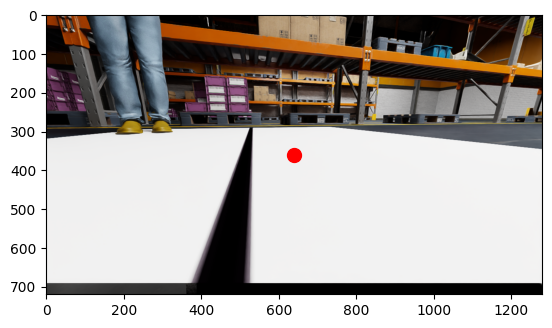

In [5]:
fig, ax = plt.subplots()
ax.imshow(imarr)
center_pixel_h = img.height / 2
center_pixel_w = img.width / 2
crop_size = (200, 200)
ax.plot(center_pixel_w, center_pixel_h, marker='o', color='red', markersize=10)
plt.show()

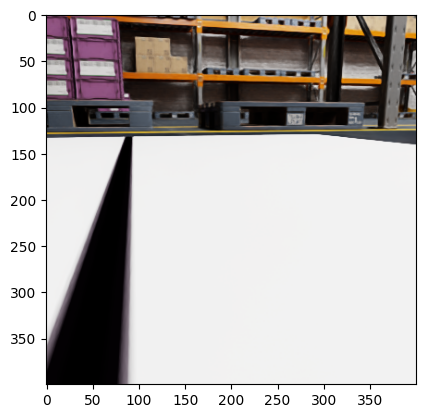

In [6]:
(left, upper, right, lower) = (center_pixel_w - crop_size[1],
                               center_pixel_h - crop_size[0],
                               center_pixel_w + crop_size[1],
                               center_pixel_h + crop_size[0])

crop = img.crop((left, upper, right, lower))
plt.imshow(crop)

In [7]:
#Approach From: A Vision-based Line Following Strategy for an Autonomous UAVcrop = img.crop((left, upper, right, lower))
#Hough Transform to get the 10 strongest peaks in the matrix (lines)
#4 Buckets of angles from 0 to 180 --> consider the interval with the most lines
#Moving average filter to include the info of the peak lines from the previous 5 frames

In [8]:
#Approach From: Vision-Based Line Following Robot in Webots
#Crop
#Grey Scale
#Gaussian Blur
#Binary Threshold
#Dilation and Erosion to get Contour
#Center Line Algorithm (from paper)


In [9]:
#Approach From: Hand ID 
#HSV Space
#Mean Filter
#Sobel Filter (Elevation Map
#OTSU Masking
#Morphology Filters
#Canny Edge Detector for Contour Map

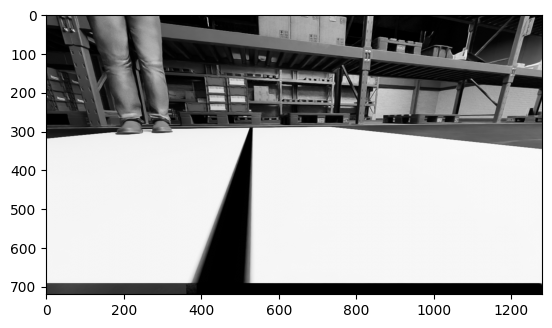

In [10]:
grayscale = rgb2gray(imarr)
plt.imshow(grayscale, cmap=plt.cm.gray)

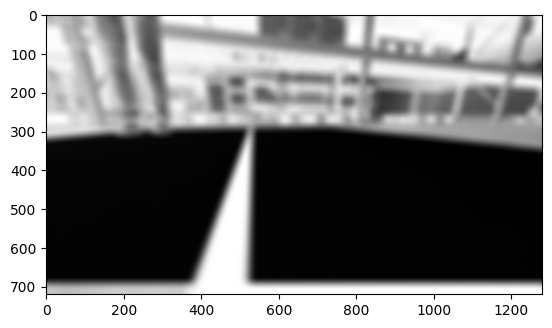

In [11]:
# kernel size is 2 * truncate val * sigma val + 1
blur = ski.filters.gaussian(grayscale, 10, truncate=1.5)
blur = ski.util.invert(blur)
plt.imshow(blur, cmap=plt.cm.gray)

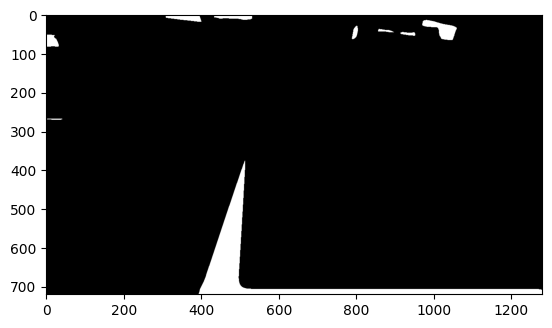

In [12]:
binary = blur > 0.99
plt.imshow(binary, cmap=plt.cm.gray)

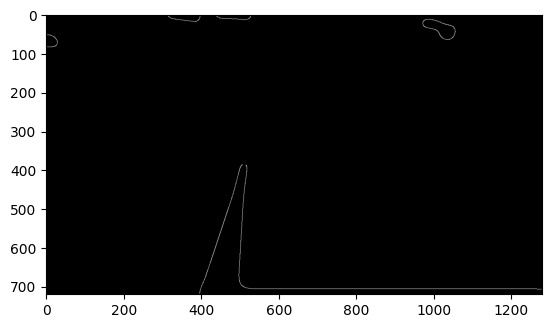

In [13]:
canny = feature.canny(binary, sigma=10)
plt.imshow(canny, cmap=plt.cm.gray)
canny = binary

840

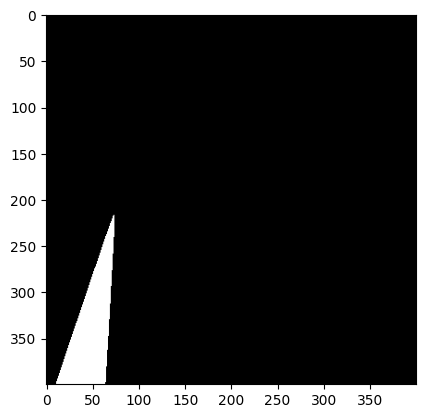

In [14]:
canny_crop = canny[int(center_pixel_h - crop_size[0]) : int(center_pixel_h + crop_size[0]), int(center_pixel_w - crop_size[1]) : int(center_pixel_w + crop_size[1])]
plt.imshow(canny_crop, cmap=plt.cm.gray)
int(center_pixel_w + crop_size[0])

In [ ]:
#Apply basic filtering / thresholding to segment out line from environment
def ImagePreProcess(imageArr, cropSize, centerH, centerW, gausStd = 10, gausTrunc = 1.5, binThresh = 0.99):
    grayscale = rgb2gray(imageArr)
    blur = ski.filters.gaussian(grayscale, gausStd, truncate=gausTrunc)
    blur = ski.util.invert(blur)
    binary = blur > binThresh
    binary_crop = binary[int(centerH - cropSize[0]) : int(centerH + crop_size[0]), int(centerW - cropSize[1]) : int(centerW + crop_size[1])]
    return binary_crop

#Calculate the center of the line using the center of inertia of binary pixel values
def CenterMoment(arr, i, j, centroid_x=0, centroid_y=0):
    sum = 0
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            sum += arr[x, y] * math.pow(x - centroid_x, j) * math.pow(y - centroid_y, i)
    return sum

#Get the central moments (center of line)
def FirstOrderCentroid(moments):

    # empty mask guard
    if moments["m00"] == 0:           
        raise ValueError("Mask has no foreground pixels")
        return 0
    
    x_hat = moments["m10"] / moments["m00"]
    y_hat = moments["m01"] / moments["m00"]

    print(f"x pos {x_hat} y pos {y_hat}")
    return x_hat, y_hat

#Get the tilt of the line 
def SecondOrderTilt(moments):

    mu20 = moments["mu20"] / moments["m00"]
    mu02 = moments["mu02"] / moments["m00"]
    mu11 = moments["mu11"] / moments["m00"]

    theta_rad = 0.5 * math.atan2(2 * mu11, mu20 - mu02)
    theta_deg = np.degrees(theta_rad) % 180 

    print(f"{theta_rad} theta degrees: {theta_deg}")

    return theta_rad



In [ ]:
img = Image.open(imdir + '/' + imlist[3])
imarr = np.asarray(img)

processedImage = ImagePreProcess(imarr, crop_size, center_pixel_h, center_pixel_w)

moments = cv2.moments(processedImage.astype(np.uint8), binaryImage=True)
centerX, centerY = FirstOrderCentroid(moments)

rad = SecondOrderTilt(moments)
#angle = AngleFromGradient(processedImage)
#deg = AngleFromGradient(processedImage)
#rad = np.radians(deg)




x pos 96.06951689725561 y pos 317.1784985257428
-1.481322997939957 theta degrees: -84.87355587762588


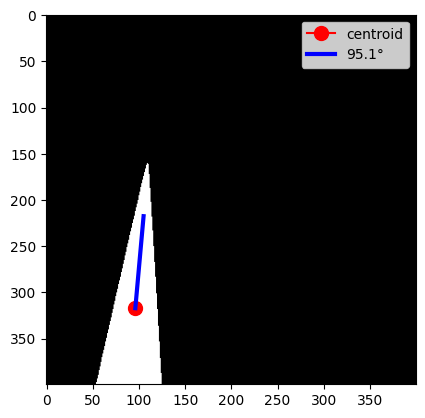

In [ ]:
length = 100
end_x = centerX + length * math.cos(rad)
end_y = centerY + length * math.sin(rad)

fig, ax = plt.subplots()
ax.imshow(processedImage, cmap = plt.cm.gray, origin='upper')
ax.plot(centerX, centerY, marker='o', color='red', markersize=10, label="centroid")
ax.plot([centerX, end_x], [centerY, end_y], "b-", linewidth=3, label=f"{np.degrees(rad) % 180 :.1f}°")
ax.set_aspect("equal")
ax.legend()
plt.show()

In [147]:

mat = processedImage.astype('uint8')
dx = cv2.Sobel(mat, cv2.CV_16S, 1, 0)
dy = cv2.Sobel(mat, cv2.CV_16S, 0, 1)
avg_dx = dx.mean()
avg_dy = dy.mean()
avg_dir = np.degrees(np.arctan2(avg_dy,avg_dx))

dir = np.degrees(np.arctan2(dy, dx))
dir = (dir + 360) % 360

avg_dir = np.degrees(np.arctan2(avg_dy,avg_dx))
avg_dir = (avg_dir + 360) % 360
print(np.sum(dir)/len(dir))
print(np.mean(dir))
print(avg_dir)


206.39140625
0.5159785
90.0
